<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebook/deep_learning/6.5.3-LSTMB16-GloVe-1m-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained embedding using LSTM

For this notebook, we will run our 16 unit LSTM using GloVe embedding with 1 million examples to see how to model does.

In general, our scores with GloVe embedding is slightly lower than random embedding score (~ 0.5).

We also know that from our random embedding notebooks, we started to see decreased performance in our model starting at 1 million examples. Since our theory is there might be something wrong without embedding layer, we hoping to see a score that is better than 500k examples: 0.32439214411478845



# Result

Random embedding with 1 million samples: 0.3532278758036526

Glove embedding with 500k samples: 0.32439214411478845

Our score: 0.2959231917086992


We are seeing a decreas of 0.03 - we are seeing a similar pattern here although the drop off with random ebedding, we saw as much as 0.06. Might be worth while to run 2 million examples to see what happens.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, No Dropout, GloVe Embedding, Balanced Weights"
FEATURE_SET_NAME = "glove"
PATIENCE = 4

SAMPLES = "1m"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename('glove_embedding-dl_prototype-report.csv')


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'

# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100




In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [6]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=109547
Number of Documents=746766
Train review vectors shape: (746766, 100)  Test review vectors shape: (248922, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [7]:
print('Indexing word vectors.')

embeddings_index = {}
with open(EMBEDDING_FILE) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [8]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 109548
embedding_matrix shape: (109549, 300)
Number of missing words from our vocabulary: 47120


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_index)+1

# building our network
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
model.add(Embedding(input_dim=vocab_size,
                            output_dim=EMBED_SIZE,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
# model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          32864700  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 32,885,073
Trainable params: 20,373
Non-trainable params: 32,864,700
_________________________________________________________________
None


In [12]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                            #   factor=0.4,
                            #   patience=PATIENCE, 
                            #   min_lr=0.00001,
                            #  mode='auto',
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42284845 3.02709736 2.2103805  1.20013018 0.37296994]
Number of training examples: 746766
Train on 597412 samples, validate on 149354 samples
Epoch 1/50
597412/597412 [==============================] - 63s 105us/sample - loss: 0.8661 - categorical_accuracy: 0.6645 - val_loss: 0.8054 - val_categorical_accuracy: 0.6837
Epoch 2/50
597412/597412 [==============================] - 54s 91us/sample - loss: 0.7927 - categorical_accuracy: 0.6900 - val_loss: 0.7932 - val_categorical_accuracy: 0.6892
Epoch 3/50
597412/597412 [==============================] - 54s 90us/sample - loss: 0.7753 - categorical_accuracy: 0.6962 - val_loss: 0.7819 - val_categorical_accuracy: 0.6942
Epoch 4/50
597412/597412 [==============================] - 53s 89us/sample - loss: 0.7657 - categorical_accuracy: 0.7000 - val_loss: 0.7698 - val_categorical_accuracy: 0.6998
Epoch 5/50
597412/597412 [==============================] - 53s 89us/sample - loss: 0.7591 - categorical_accuracy: 0.7025 - val_loss: 0

Number of test: 248922
Running model.evaluate...
248922/248922 [==============================] - 35s 139us/sample - loss: 0.7492 - categorical_accuracy: 0.7072
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(248922, 5)
Getting classification report...
Accuracy: 70.72%


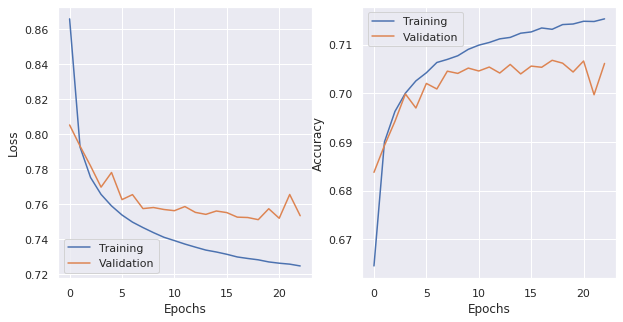


Confusion Matrix
[[ 29525   1480   1969    398   1791]
 [  8086   1991   3933    837   1651]
 [  4024   1369   7685   4346   4935]
 [  1236    248   3622  12214  23995]
 [  1534    123   1389   5925 124616]]

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.84      0.74     35163
           2       0.38      0.12      0.18     16498
           3       0.41      0.34      0.38     22359
           4       0.51      0.30      0.38     41315
           5       0.79      0.93      0.86    133587

    accuracy                           0.71    248922
   macro avg       0.55      0.51      0.51    248922
weighted avg       0.67      0.71      0.67    248922



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

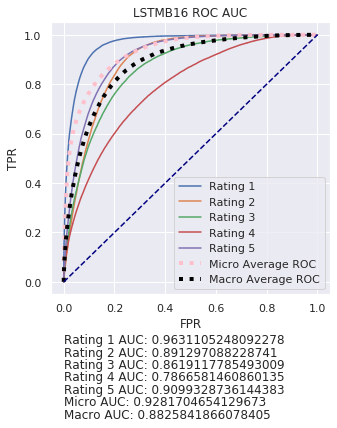

In [13]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [14]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.29361596365641796


**Save off various files**

In [15]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16-1x16-glove-sampling_none-995688-100-star_rating
Saving to report file: drive/My Drive/Springboard/capstone/reports/glove_embedding-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/glove_embedding-dl_prototype-report.csv
{'model_name': 'LSTMB16', 'architecture': '1x16', 'description': '1 Layer 16 LSTM Units, No Dropout, GloVe Embedding, Balanced Weights', 'classification_report': '{"1": {"precision": 0.6649026010584393, "recall": 0.8396610073088189, "f1-score": 0.7421325155841544, "support": 35163}, "2": {"precision": 0.38207637689502977, "recall": 0.12068129470238817, "f1-score": 0.18342622875305176, "support": 16498}, "3": {"precision": 0.4132164748897731, "recall": 0.3437094682230869, "f1-score": 0.3752716263398198, "support": 22359}, "4": {"precision": 0.5149241146711636, "recall": 0.2956311267094276, "f1-score": 0.3756131313907896, "support": 41315}, "5": {"precision": 0.7937931561648024, "recall": 0.9328452618892557, "f

# Test That Our Models Saved Correctly

In [16]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


248922/248922 [==============================] - 115s 462us/sample - loss: 0.7492 - categorical_accuracy: 0.7072
Accuracy: 70.72%


In [17]:
print(datetime.now())

2020-02-15 01:30:03.891760
